In [1]:
## Load necessary libraries

### General purpose
import numpy as np
import pandas as pd
import math
from glob import glob
import string
import warnings

from MEDUSSA.measure import SkeletonMeasure
from scipy.ndimage import distance_transform_edt, binary_fill_holes
from skimage.morphology import skeletonize, binary_erosion, binary_dilation
from skimage import io

### Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import seaborn as sns

### Bayesian analysis
import pymc
from pymc import HalfCauchy, Model, Normal, sample

letters = list(string.ascii_uppercase)

warnings.filterwarnings("ignore")


In [18]:
GT_cells_path = '/Users/reyesmatte/Desktop/SingleCells/Ecoli/Ecoli_GT/'
Omni_cells_path = '/Users/reyesmatte/Desktop/SingleCells/Ecoli/Ecoli_Omni/'

cells = sorted(glob(f'{GT_cells_path}*.tif'))

cells = [cell.split('/')[-1].split('.')[0] for cell in cells]

print(len(cells))

gt_masks = [binary_fill_holes(io.imread(f'{GT_cells_path}{cell}.tif')) > 0 for cell in cells]
gt_masks = [np.pad(binary_dilation(binary_erosion(cell)),pad_width=4) for cell in gt_masks]
gt_skeletons = [skeletonize(cell) for cell in gt_masks]
gt_distances = [distance_transform_edt(cell) for cell in gt_masks]

omni_masks = [binary_fill_holes(io.imread(f'{Omni_cells_path}{cell}.tif')) > 0 for cell in cells]
omni_masks = [np.pad(binary_dilation(binary_erosion(cell)),pad_width=4) for cell in omni_masks]
omni_skeletons = [skeletonize(cell) for cell in omni_masks]
omni_distances = [distance_transform_edt(cell) for cell in omni_masks]

864


In [19]:
def SizeDataFrame_mini(skeletons,distances):

    measures = [SkeletonMeasure(skel,dist) for skel,dist in zip(skeletons,distances)]

    L = [metric[0] for metric in measures]
    w = [np.mean(metric[1]) for metric in measures]
    S = [metric[2] for metric in measures]
    V = [metric[3] for metric in measures]
    
    df = pd.DataFrame()

    df.insert(0,'Width',w)
    df.insert(1,'Length',L)
    df.insert(2,'SurfaceArea',S)
    df.insert(3,'Volume',V)

    return df

In [30]:
metrics_GT = ['Width_GT','Length_GT','SurfaceArea_GT','Volume_GT']
metrics_Omni = ['Width_Omni','Length_Omni','SurfaceArea_Omni','Volume_Omni']

GT_sizes = SizeDataFrame_mini(gt_skeletons,gt_distances)
Omni_sizes = SizeDataFrame_mini(omni_skeletons,omni_distances)

GT_sizes.columns = metrics_GT
Omni_sizes.columns = metrics_Omni

joint_df = pd.concat([GT_sizes,Omni_sizes],axis=1)
joint_df.insert(0,'Cell',cells)

joint_df = joint_df[joint_df['Width_GT'] > 0]

joint_df.to_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/SingleCells_measurements.csv')

In [36]:
full_data = pd.read_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/SingleCells_measurements.csv')

quantiles = [0,0.2,0.4,0.5,0.6,0.8,1]

w = np.round(np.array(full_data['Width_GT']),2)
L = np.round(np.array(full_data['Length_GT']),2)

wvals = np.round(np.quantile(w,quantiles),2)
Lvals = np.round(np.quantile(L,quantiles),2)

cells_w = []
cells_L = []

for wv in wvals:
    idx = np.where(w==wv)[0][0]
    cells_w.append(cells[idx])

for Lv in Lvals:
    idx = np.where(L==Lv)[0][0]
    cells_L.append(cells[idx])
    




## Parameter sampling for error propagation on segmentation results

In [37]:
kept_cells = np.unique(cells_w+cells_L)[1:]

basedir = '/Users/reyesmatte/Desktop/SingleCells/Ecoli/SingleCells/'
basedir_gt = '/Users/reyesmatte/Desktop/SingleCells/Ecoli/Ecoli_GT/'
basedir_omni = '/Users/reyesmatte/Desktop/SingleCells/Ecoli/Ecoli_Omni/'

kept_cells_ = [io.imread(f'{basedir}{cell}.tif') for cell in kept_cells]
kept_gt_masks = [io.imread(f'{basedir_gt}{cell}.tif')>0 for cell in kept_cells]
kept_omni_masks = [io.imread(f'{basedir_omni}{cell}.tif')>0 for cell in kept_cells]

for cell in kept_cells_:
    print(cell.shape)


(79, 83)
(46, 77)
(78, 89)
(53, 71)
(73, 69)
(70, 86)
(74, 91)
(61, 61)
(58, 40)
(84, 77)
(56, 61)
(66, 91)
(47, 77)


In [38]:
newcells = []

for cell in kept_cells_:
    template = np.zeros((110,110))
    template += np.mean(cell[:,:5])
    y,x = cell.shape

    fromy = (110-y)//2
    fromx = (110-x)//2

    template[fromy:fromy+y,fromx:fromx+x] = cell

    newcells.append(template)

newGT = []

for cell in kept_gt_masks:
    template = np.zeros((110,110))
    template += np.mean(cell[:,:5])
    y,x = cell.shape

    fromy = (110-y)//2
    fromx = (110-x)//2

    template[fromy:fromy+y,fromx:fromx+x] = cell

    newGT.append(template>0)

newOmni = []

for cell in kept_omni_masks:
    template = np.zeros((110,110))
    template += np.mean(cell[:,:5])
    y,x = cell.shape

    fromy = (110-y)//2
    fromx = (110-x)//2

    template[fromy:fromy+y,fromx:fromx+x] = cell

    newOmni.append(template>0)

In [39]:
ncols = 12

fig,ax = plt.subplots(dpi=300,ncols=ncols,nrows=4,figsize=(60,20))

for i in range(ncols):
    
    patch = patches.Rectangle((5, 100), 39, 4, linewidth=1, edgecolor='white', facecolor='white')

    ax[0,i].imshow(newcells[i],cmap='inferno')
    ax[0,i].add_patch(patch)
    ax[0,i].axis('off')

    ax[1,i].imshow(newGT[i],cmap='inferno')
    ax[1,i].axis('off')

    ax[2,i].imshow(newOmni[i],cmap='inferno')
    ax[2,i].axis('off')

    ax[3,i].imshow(newGT[i]^newOmni[i],cmap='inferno')
    ax[3,i].axis('off')

fig.tight_layout()

fig.savefig('/Users/reyesmatte/Desktop/Imaging_paper/FigS4/Ecoli_cells_masks.png')

<Figure size 4800x1200 with 0 Axes>

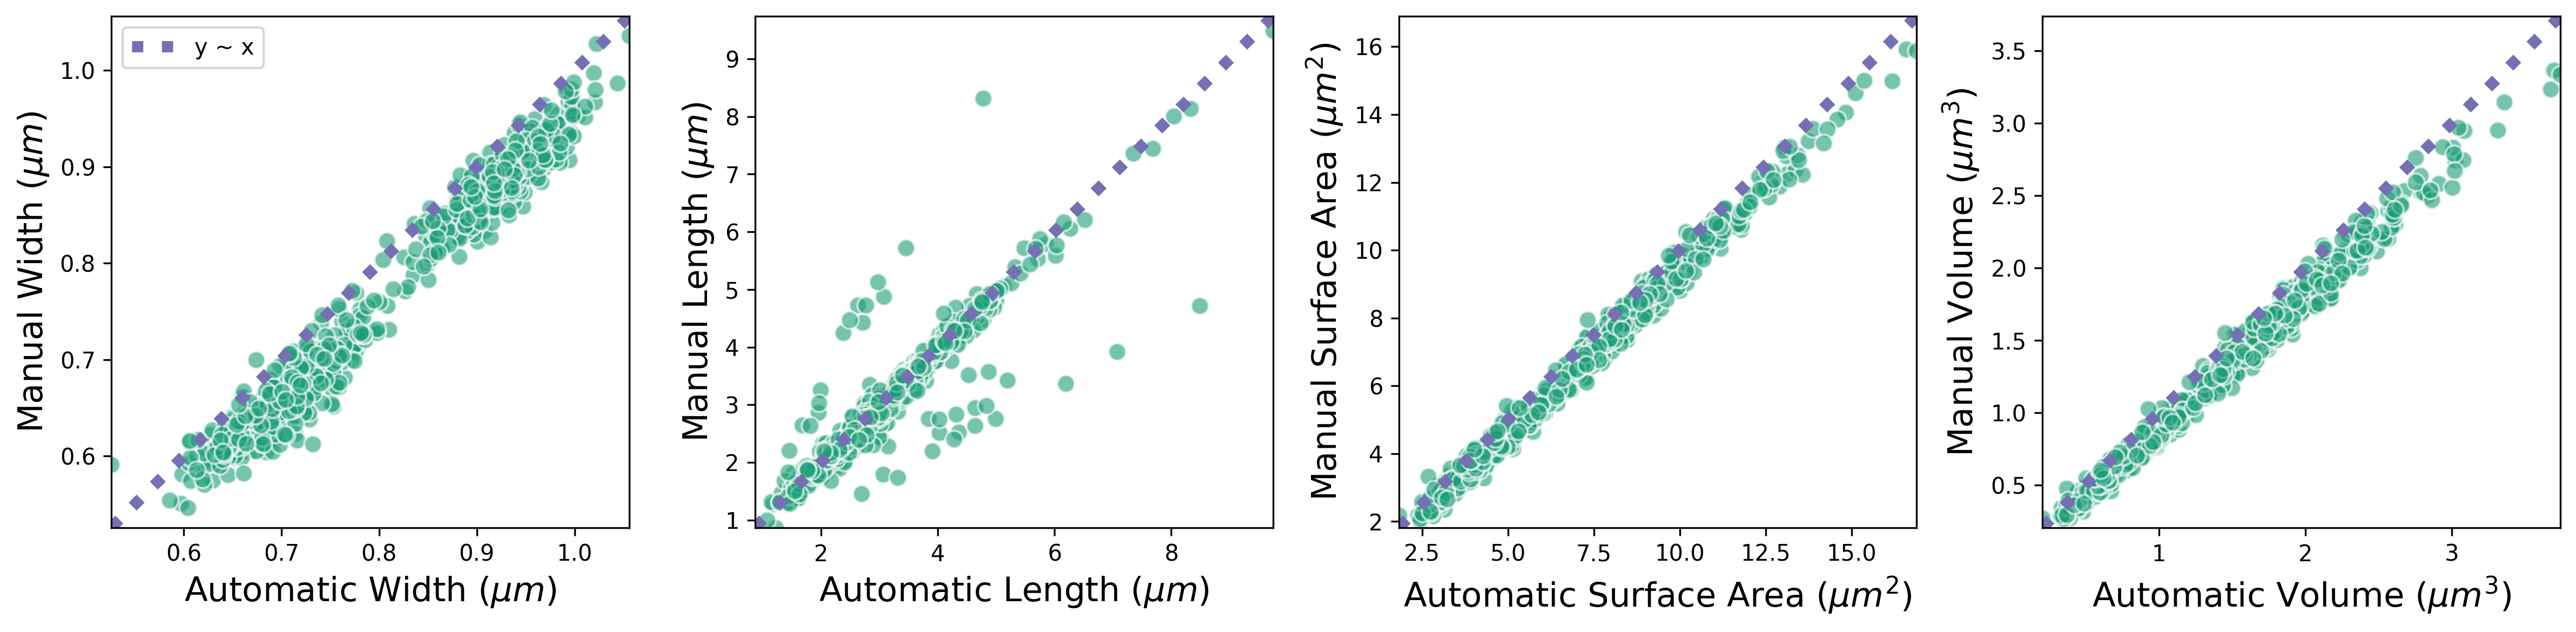

In [41]:
## Load the data and plot the metrics

full_data = pd.read_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/SingleCells_measurements.csv')

metrics = ['Width','Length','SurfaceArea','Volume']

plt.figure(figsize=(16,4),dpi=300)

fig,ax = plt.subplots(figsize=(16,4),dpi=300, nrows=1, ncols=4)

i = 0

for i,metric in enumerate(metrics):

    if metric == 'SurfaceArea':
        unit = '$µm^2$'
        metric_ = 'Surface Area'
    elif metric == 'Volume':
        unit = '$µm^3$'
        metric_ = metric
    else:
        unit = '$µm$'
        metric_ = metric
    
    y = np.array(full_data[f'{metric}_GT'])
    x = np.array(full_data[f'{metric}_Omni'])
    xy = np.stack([x,y])
    lowlim = xy.min()
    highlim = xy.max()

    
    ax[i].scatter(x,y,c='#1b9e77',alpha=0.6,s=60,edgecolor='w')
    ax[i].plot([lowlim,highlim],[lowlim,highlim],c='#7570b3',linewidth=5,linestyle=':',label="y ~ x")

    ax[i].set_xlabel(f'Automatic {metric_} ({unit})',fontsize=15)
    ax[i].set_ylabel(f'Manual {metric_} ({unit})',fontsize=15)
    ax[i].set_xlim(lowlim,highlim)
    ax[i].set_ylim(lowlim,highlim)
    #plt.xticks(fontsize=12.5)
    #plt.yticks(fontsize=12.5)


ax[0].legend()

fig.tight_layout()
plt.savefig('/Users/reyesmatte/Desktop/Imaging_paper/Fig4/OmniGT_measurements.png')

### How to perform the transformations?

We'll use the [PYMC](https://www.pymc.io/welcome.html) library for sampling pairs of values (slope, intercept and standard deviation) using a Bayesian statistics approach. Since we have four different metrics in our dataframe, we'll iterate through them to perform the sampling. The workflos is as follows, borrowing heavily from the [GLM example](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html) in the PYMC documentation:

- Define your x and y vectors for which you want to perform the linear fit
  * In our case, x is the `Ground Truth` measurements, and y the `Omnipose` measurements in our data, as we wish to go from a segmentation-resulting size to a ground-truth size

- Define the prior distributions for sampling the parameters. In this case, we'll use a normal distribution for both slope and intercept, and a half-Cauchy for the standard deviation

- Define the "likelihood", or the function that our data will follow. For our data, this is: y = intercept + slope * x

- Sample values that fit the data. PYMC uses the [NUTS sampler](https://arxiv.org/abs/1111.4246). You can define the number of chains and the number of draws per chain

- The result will be one distribution of sampled values per chain, per parameter. You can inspect them and see, for example, their spread and similarity

In [42]:
## Construct iterative loop through measurements

metrics = ['Width','Length','SurfaceArea','Volume']

df_list = []

for metric in metrics:

    y = np.array(full_data[f'{metric}_GT'])
    x = np.array(full_data[f'{metric}_Omni'])

    RANDOM_SEED = 8927
    rng = np.random.default_rng(RANDOM_SEED)

    with Model() as model:

        ## Define priors
        sigma = HalfCauchy('sigma', beta=10)
        intercept = Normal('Intercept', 0, sigma=20)
        slope = Normal('slope', 0, sigma=20)

        ## Define likelihood
        likelihood = Normal('y', mu = intercept + slope * x, sigma=sigma, observed=y)

        ## For inference, draw N posterior samples
        idata = sample(3000)

    ## Obtain posterior distributions
    post_slope = np.array(idata.posterior.slope)
    post_intercept = np.array(idata.posterior.Intercept)
    post_sigma = np.array(idata.posterior.sigma)

    ## Each array has a shape of (4,3000), denoting the chains and draws, respectively
    ## Iterate through each chain to keep the information for sampling after

    for i in range(post_slope.shape[0]):
        
        mini_df = pd.DataFrame()
        mini_df.insert(0,'Sigma',post_sigma[i])
        mini_df.insert(0,'Intercept',post_intercept[i])
        mini_df.insert(0,'Slope',post_slope[i])
        mini_df.insert(0,'Chain',i)
        mini_df.insert(0,'Metric',metric)

        df_list.append(mini_df)

df_posteriors = pd.concat(df_list,ignore_index=True)
df_posteriors.to_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/posterior_segmentation_measurements.csv')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


In [43]:
df_posteriors = pd.read_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/posterior_segmentation_measurements.csv')

Text(0, 0.5, 'Sampled Sigma (frequency)')

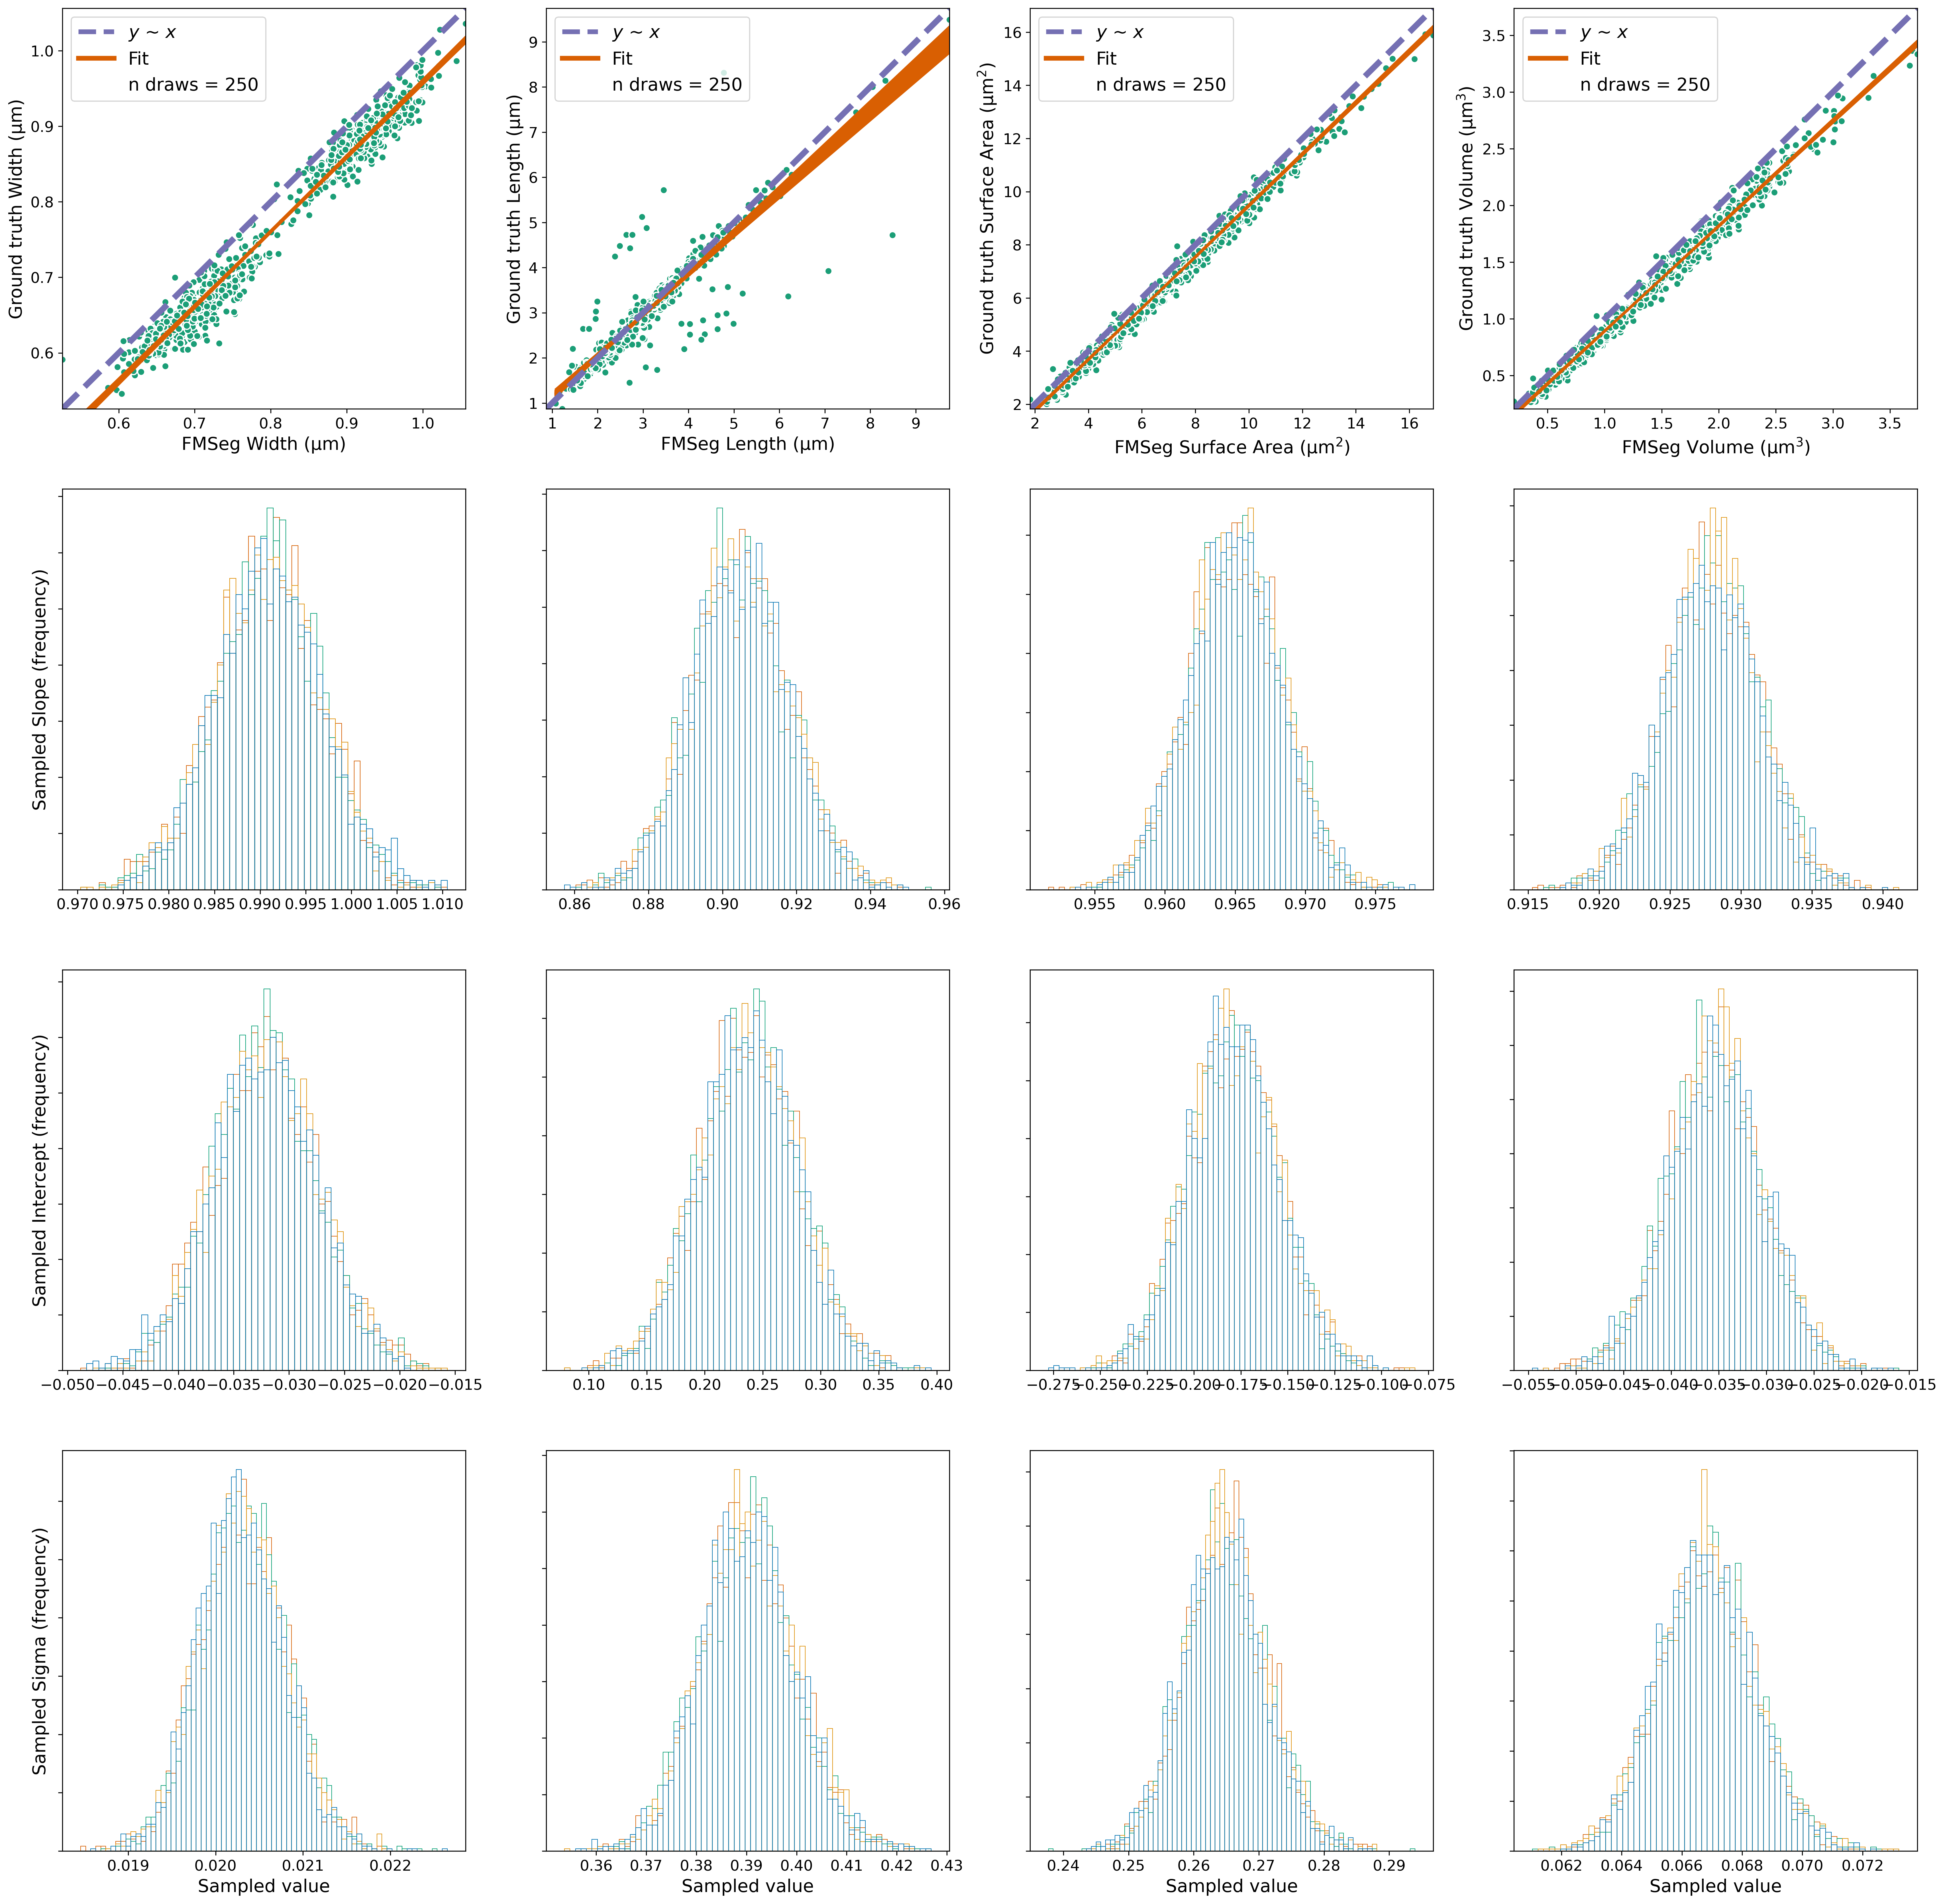

In [44]:
## Report sampling examples for the cell size metrics, as well as the distributions of the sampled slope, intercept, and standard deviation

fig,ax = plt.subplots(figsize=(28,28),dpi=300, nrows=4, ncols=4)

k = 0
r = 0

lines = [Line2D([0], [0], color='#7570b3', linestyle='--',linewidth=4),
        Line2D([0], [0], color='#d95f02',linestyle='-',linewidth=4),
        Line2D([0], [0], color='w')]
labels = ['$y$ ~ $x$','Fit','n draws = 250']

summary_vecs = []

for c,metric in enumerate(metrics):

    if metric == 'SurfaceArea':
        unit = 'µm$^2$'
        metric_ = 'Surface Area'
    elif metric == 'Volume':
        unit = 'µm$^3$'
        metric_ = metric
    else:
        unit = 'µm'
        metric_ = metric
        
    y = np.array(full_data[f'{metric}_GT'])
    x = np.array(full_data[f'{metric}_Omni'])
    xy = np.stack([x,y])
    lowlim = xy.min()
    highlim = xy.max()

    subdf_posterior = df_posteriors[df_posteriors['Metric'] == metric]
    
    x_ = np.array(sorted(x))

    m = np.array(subdf_posterior['Slope'])
    n = np.array(subdf_posterior['Intercept'])

    sample_size = 250
    
    idxs = np.random.randint(low=0,high=12000,size=sample_size)

    ax[r,c].set_xlim(lowlim,highlim)
    ax[r,c].set_ylim(lowlim,highlim)
    
    for i in idxs:

        m_ = m[i]
        n_ = n[i]

        y_ = x_*m_+n_

        ax[r,c].plot(x_,y_,c='#d95f02')
        
    ax[r,c].plot([lowlim,highlim],[lowlim,highlim],c='#7570b3',linewidth=5,linestyle='--')
    ax[r,c].scatter(x,y,c='#1b9e77',edgecolor='w')
    ax[r,c].set_ylabel(f'Ground truth {metric_} ({unit})',fontsize=15)
    ax[r,c].set_xlabel(f'FMSeg {metric_} ({unit})',fontsize=15)
    ax[r,c].set_xticklabels(ax[r,c].get_xticklabels(),fontsize=12.5)
    ax[r,c].set_yticklabels(ax[r,c].get_yticklabels(),fontsize=12.5)
    
    r += 1

    m_mu, m_sigma = np.mean(subdf_posterior['Slope']), np.std(subdf_posterior['Slope'])
    n_mu, n_sigma = np.mean(subdf_posterior['Intercept']), np.std(subdf_posterior['Intercept'])
    sigma_mu, sigma_sigma = np.mean(subdf_posterior['Sigma']), np.std(subdf_posterior['Sigma'])
    
    sns.histplot(x=subdf_posterior['Slope'],hue = subdf_posterior['Chain'], legend=False, palette=sns.color_palette('colorblind'),ax=ax[r,c],stat='probability',fill=False)
    ax[r,c].set_xticklabels(ax[r,c].get_xticklabels(),fontsize=12.5)
    ax[r,c].set_xlabel('',fontsize=0)
    ax[r,c].set_ylabel('',fontsize=15)
    
    r += 1

    sns.histplot(x=subdf_posterior['Intercept'],hue = subdf_posterior['Chain'], legend=False, palette=sns.color_palette('colorblind'),ax=ax[r,c],stat='probability',fill=False)
    ax[r,c].set_xticklabels(ax[r,c].get_xticklabels(),fontsize=12.5)
    ax[r,c].set_xlabel('',fontsize=0)
    ax[r,c].set_ylabel('',fontsize=15)
    
    r += 1

    sns.histplot(x=subdf_posterior['Sigma'],hue = subdf_posterior['Chain'], legend=False, palette=sns.color_palette('colorblind'),ax=ax[r,c],stat='probability',fill=False)
    ax[r,c].set_xticklabels(ax[r,c].get_xticklabels(),fontsize=12.5)
    ax[r,c].set_xlabel('',fontsize=0)
    ax[r,c].set_ylabel('',fontsize=15)
    
    r = 0

    mu_m = np.round(subdf_posterior['Slope'].mean(),3)
    std_m = np.round(subdf_posterior['Slope'].std(),3)
    mu_n = np.round(subdf_posterior['Intercept'].mean(),3)
    std_n = np.round(subdf_posterior['Intercept'].std(),3)
    mu_s = np.round(subdf_posterior['Sigma'].mean(),3)
    std_s = np.round(subdf_posterior['Sigma'].std(),3)
         
    vec = [metric, f'{mu_m} ± {std_m}', f'{mu_n} ± {std_n}', f'{mu_s} ± {std_s}']

    summary_vecs.append(vec)

for i in range(4):
    ax[0,i].legend(lines,labels,loc='upper left',fontsize=15)
    ax[3,i].set_xlabel('Sampled value',fontsize=15)

empty_labels = ['' for i in range(8)]

for r in range(1,4):
    for c in range(4):
        ax[r,c].set_yticklabels(empty_labels)

ax[1,0].set_ylabel('Sampled Slope (frequency)',fontsize=15)
ax[2,0].set_ylabel('Sampled Intercept (frequency)',fontsize=15)
ax[3,0].set_ylabel('Sampled Sigma (frequency)',fontsize=15)

#fig.tight_layout()
#fig.savefig('/Users/reyesmatte/Desktop/Imaging_paper/FigS4/Bayesian_sampling_results.png')